# NOTES 

- TT races are slower because no drafting and noone around to challenge yourself to catch up. 
- RR races have draftinig and people take turns to lead the pack. once you lose the pack, it's difficult to catch up to the pack. 
- **very important** to record the reason why you modified the data
- MUST HAVE MARKDOWN / COMMENTS. markdown 
- to get full marks, need to do challenge questions
- factor plot from week 4 workshop will be useful for the challenge question 

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls. 

### Notes: these questions above are usually asked by a demand expert (lecture w4)

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [1]:
import gpxpy
import gpxpy.gpx
from gpxutils import parse_gpx 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the four data files
rr16 = parse_gpx('files/Calga_RR_2016.gpx')
tt16 = parse_gpx('files/Calga_TT_2016.gpx')
rr19 = parse_gpx('files/Calga_RR_2019.gpx')
tt19 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
rr16.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2821.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,158.394401,0.017381,-0.003756,34.933085,1.843318
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,11.304588,0.015695,0.458872,10.738677,1.692364
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,1.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,26.656312,1.000000
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,33.307339,1.000000
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,166.000000,0.016899,0.400000,42.871885,2.000000
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,92.749036,9.000000


In [4]:
# checking the shapes to confirm they are of large sizes (don't want to scroll through the dataset, will have to use code
# access the dataset if I face any issues)

print(rr16.shape, tt16.shape, rr19.shape, tt19.shape)

(2822, 11) (1541, 11) (5503, 11) (2655, 11)


# Q1 what is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.

`describe()` tells us a lot about all variables, but we just want one variable at a time. we can also check the sum of the distance travelled at each observation 

In [5]:
rr16['distance'].sum()

49.04858574628638

In [6]:
# 'distance' is the total distance travelled at each 'checkpoint'.

print(f"Total distance travelled for the 2016 road racer is {rr16['distance'].sum():.4} Km") # taking the sum will tell
#us how far the cyclist travelled as it adds all the distances between each checkpoint. 

Total distance travelled for the 2016 road racer is 49.05 Km


We can confirm the above by noting the timestamps at the start and end of the race and multiplying it by the speed of the rider. Using simple formulae: 

$$\text{Total distance = speed}\times\text{time}$$
$$\text{km = km/hr}\times\text{hr}$$

In [7]:
rr16['speed'].mean()

34.93308475482947

In [8]:
time = 5*60*60 + 29*60 + 21 - 4*60*60 + 2*60 + 41 # converting the time taken to seconds then taking the difference between
# the start and end time 

speed = rr16['speed'].mean() /(60*60) #converting the mean speed to Km/s

(time * speed)

53.58347056004676

The result is similar, differences may be attributed to the fact we used a mean speed. The result of 49.05Km has a varying speed included. At each observation, there is a distance measured and a speed measured. So the sum of distance is a better measurement than using the mean speed and the time taken to complete the race. 

### Unsure of what exactly is required in this question

The summary will be for the following information:
<ul>
    <li> the heart rate mean and max (no min because min will be before the race commences) </li>
    <li> temperature mean and max (no min because min will be before the race commences) </li>
    <li> speed mean and max </li>
    <li> time taken to complete the race </li>
    <li> total distance travelled </li>
    <li> mean and max cadence</li>
    <li> mean and max power </li>
    
</ul>

In [9]:
print(f"The mean heart rate for the road racer in 2016 is {rr16['hr'].mean()} bpm")

The mean heart rate for the road racer in 2016 is 158.39440113394755 bpm


In [10]:
print(f"The max heart rate for the road racer in 2016 is {rr16['hr'].max()} bpm")

The max heart rate for the road racer in 2016 is 205.0 bpm


In [11]:
print(f"The mean temperature for the road racer in 2016 is {rr16['temperature'].mean()} degrees Celcius")

The mean temperature for the road racer in 2016 is 25.280652019844084 degrees Celcius


In [12]:
print(f"The max temperature for the road racer in 2016 is {rr16['temperature'].max()} degrees Celcius") 

The max temperature for the road racer in 2016 is 30.0 degrees Celcius


In [13]:
print(f"The mean speed for the road racer in 2016 is {rr16['speed'].mean()} Km/hr")

The mean speed for the road racer in 2016 is 34.93308475482947 Km/hr


In [14]:
print(f"The max speed for the road racer in 2016 is {rr16['speed'].max()} Km/hr")

The max speed for the road racer in 2016 is 92.74903649913952 Km/hr


In [15]:
print(f"The time taken for the road racer in 2016 is {rr16['distance'].sum() / rr16['speed'].mean()} hours")

The time taken for the road racer in 2016 is 1.404072560168207 hours


In [16]:
print(f"The total distance travelled for the road racer in 2016 is { rr16['distance'].sum() } Km")

The total distance travelled for the road racer in 2016 is 49.04858574628638 Km


In [17]:
print(f"The mean cadence for the road racer in 2016 is {rr16['cadence'].mean() } rpm")

The mean cadence for the road racer in 2016 is 65.98795180722891 rpm


In [18]:
print(f"The max cadence for the road racer in 2016 is {rr16['cadence'].max() } rpm")

The max cadence for the road racer in 2016 is 117.0 rpm


In [19]:
print(f"The power produced by the road racer in 2016 is null in the DF. This column should be dropped")

The power produced by the road racer in 2016 is null in the DF. This column should be dropped


As we can see, this is a very tedious task. This would work best in a function

In [20]:
def summaryFn(myDF, raceTypeString, yearString):
    
    print(f"The mean heart rate for the {raceTypeString} racer in {yearString} is {myDF['hr'].mean():.4} bpm")
    print(" ")
    print(f"The max heart rate for the {raceTypeString} racer in {yearString} is {myDF['hr'].max():.4} bpm")
    print(" ")
    print(f"The mean temperature for the {raceTypeString} racer in {yearString} is {myDF['temperature'].mean():.4} degrees Celcius")
    print(" ")
    print(f"The max temperature for the {raceTypeString} racer in {yearString} is {myDF['temperature'].max():.4} degrees Celcius") 
    print(" ")
    print(f"The mean speed for the {raceTypeString} racer in {yearString} is {myDF['speed'].mean():.4} Km/hr")
    print(" ")
    print(f"The max speed for the {raceTypeString} racer in {yearString} is {myDF['speed'].max():.4} Km/hr")
    print(" ")
    print(f"The time taken for the {raceTypeString} racer in {yearString} is {myDF['distance'].sum() / myDF['speed'].mean():.4} hours")
    print(" ")
    print(f"The total distance travelled for the {raceTypeString} racer in {yearString} is { myDF['distance'].sum():.4} Km")
    print(" ")
    print(f"The mean cadence for the {raceTypeString} racer in {yearString} is {myDF['cadence'].mean():.4} rpm")
    print(" ")
    print(f"The max cadence for the {raceTypeString} racer in {yearString} is {myDF['cadence'].max():.4} rpm")

In [21]:
summaryFn(rr16, 'road', '2016')

The mean heart rate for the road racer in 2016 is 158.4 bpm
 
The max heart rate for the road racer in 2016 is 205.0 bpm
 
The mean temperature for the road racer in 2016 is 25.28 degrees Celcius
 
The max temperature for the road racer in 2016 is 30.0 degrees Celcius
 
The mean speed for the road racer in 2016 is 34.93 Km/hr
 
The max speed for the road racer in 2016 is 92.75 Km/hr
 
The time taken for the road racer in 2016 is 1.404 hours
 
The total distance travelled for the road racer in 2016 is 49.05 Km
 
The mean cadence for the road racer in 2016 is 65.99 rpm
 
The max cadence for the road racer in 2016 is 117.0 rpm


In [22]:
summaryFn(rr16, 'road', '2016')

The mean heart rate for the road racer in 2016 is 158.4 bpm
 
The max heart rate for the road racer in 2016 is 205.0 bpm
 
The mean temperature for the road racer in 2016 is 25.28 degrees Celcius
 
The max temperature for the road racer in 2016 is 30.0 degrees Celcius
 
The mean speed for the road racer in 2016 is 34.93 Km/hr
 
The max speed for the road racer in 2016 is 92.75 Km/hr
 
The time taken for the road racer in 2016 is 1.404 hours
 
The total distance travelled for the road racer in 2016 is 49.05 Km
 
The mean cadence for the road racer in 2016 is 65.99 rpm
 
The max cadence for the road racer in 2016 is 117.0 rpm


In [23]:
summaryFn(tt16, 'time trial', '2016')

The mean heart rate for the time trial racer in 2016 is 170.9 bpm
 
The max heart rate for the time trial racer in 2016 is 251.0 bpm
 
The mean temperature for the time trial racer in 2016 is 10.95 degrees Celcius
 
The max temperature for the time trial racer in 2016 is 13.0 degrees Celcius
 
The mean speed for the time trial racer in 2016 is 33.53 Km/hr
 
The max speed for the time trial racer in 2016 is 162.5 Km/hr
 
The time taken for the time trial racer in 2016 is 0.7397 hours
 
The total distance travelled for the time trial racer in 2016 is 24.8 Km
 
The mean cadence for the time trial racer in 2016 is 83.28 rpm
 
The max cadence for the time trial racer in 2016 is 118.0 rpm


In [24]:
summaryFn(rr19, 'road', '2019')

The mean heart rate for the road racer in 2019 is 139.0 bpm
 
The max heart rate for the road racer in 2019 is 170.0 bpm
 
The mean temperature for the road racer in 2019 is 5.998 degrees Celcius
 
The max temperature for the road racer in 2019 is 7.0 degrees Celcius
 
The mean speed for the road racer in 2019 is 33.88 Km/hr
 
The max speed for the road racer in 2019 is 70.37 Km/hr
 
The time taken for the road racer in 2019 is 1.529 hours
 
The total distance travelled for the road racer in 2019 is 51.79 Km
 
The mean cadence for the road racer in 2019 is 70.0 rpm
 
The max cadence for the road racer in 2019 is 120.0 rpm


In [25]:
summaryFn(tt19, 'time trial', '2019')

The mean heart rate for the time trial racer in 2019 is 152.7 bpm
 
The max heart rate for the time trial racer in 2019 is 166.0 bpm
 
The mean temperature for the time trial racer in 2019 is 10.19 degrees Celcius
 
The max temperature for the time trial racer in 2019 is 13.0 degrees Celcius
 
The mean speed for the time trial racer in 2019 is 33.06 Km/hr
 
The max speed for the time trial racer in 2019 is 63.3 Km/hr
 
The time taken for the time trial racer in 2019 is 0.7375 hours
 
The total distance travelled for the time trial racer in 2019 is 24.38 Km
 
The mean cadence for the time trial racer in 2019 is 89.98 rpm
 
The max cadence for the time trial racer in 2019 is 111.0 rpm


We will most likely have to access some of this information later on so we can expect to modify the function such that it returns the required information. 

Dropping the 'power' column from the DFs, only tt_2019 has the power field filled:

using help from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [26]:
rr16= rr16.drop(['power'], axis=1)
rr19= rr19.drop(['power'], axis=1)
tt16= tt16.drop(['power'], axis=1)

# Q2: Compare the range of speeds for each ride, are time trials faster than road races? 

Let's start by modifying the `summaryFn` from before so that we can easily call the summarised information

In [27]:
def summaryFn2(myDF, stringDF):
    
    #___________________________________________________________________________________________
    # storing the required information 
    
    hrMean = myDF['hr'].mean()
    hrMax =  myDF['hr'].max()
    
    tempMean = myDF['temperature'].mean()
    tempMax = myDF['temperature'].max()
    
    speedMean = myDF['speed'].mean()
    speedMax = myDF['speed'].max()
    
    timeTaken = myDF['distance'].sum() / myDF['speed'].mean()
    
    totalDist = myDF['distance'].sum()
    
    cadenceMean = myDF['cadence'].mean()
    cadenceMax = myDF['cadence'].max()
    
    
    #___________________________________________________________________________________________
    # creating the DF
    
    listDF = list([hrMean , hrMax , tempMean,  tempMax,  speedMean,  timeTaken,  totalDist,  cadenceMean,  cadenceMax])
    # we want a list of of the values we just determined so that we can put it in a DF
    
    newDF = {'DF': [stringDF], 'hrMean':[listDF[0]], 'hrMax': [listDF[1]],'tempMean':[listDF[2]] , 'tempMax': [listDF[3]],
              'speedMean': [listDF[4]], 'timeTaken': [listDF[5]], 'totalDist':[listDF[6]], 'cadenceMean': [listDF[7]] ,
              'cadenceMax':[listDF[8]]} # this will create a Dict, but we want a pandas dataframe so we must convert it
    
    newDF = pd.DataFrame(newDF)
    
    return newDF

In [28]:
tt16_summary = summaryFn2(tt16, 'tt16')
rr16_summary = summaryFn2(rr16, 'rr16')
tt19_summary = summaryFn2(tt19, 'tt19')
rr19_summary = summaryFn2(rr19, 'rr19')

#appending all the DFs 
summaryDF = tt16_summary.append([rr16_summary, tt19_summary, rr19_summary])
summaryDF

,DF,hrMean,hrMax,tempMean,tempMax,speedMean,timeTaken,totalDist,cadenceMean,cadenceMax
0,tt16,170.939650,251.0,10.953277,13.0,33.529963,0.739723,24.802887,83.277093,118.0
0,rr16,158.394401,205.0,25.280652,30.0,34.933085,1.404073,49.048586,65.987952,117.0
0,tt19,152.741243,166.0,10.194350,13.0,33.057824,0.737500,24.380145,89.979661,111.0
0,rr19,138.998546,170.0,5.997819,7.0,33.879861,1.528611,51.789133,70.004906,120.0


Recall: the units of measurement are as follows: bpm, bpm, degrees celcius, degrees celcius, km/h, km/h, hours, km, watts, watts, respective. 

Analysis: Comparing the 2016 and 2019 races, it seems the rider has improved in terms of fitness levels as the max and mean hr are both lower for the later race. the tt races seem to travel similar distances and the rr is only slightly larger in the 2019 race. 

Looking at `summaryDF`, we can see the timeTaken for each race type. the time trials (tt) taken significantly less time to complete but also have roughlyl half the total distance travelled (totalDist). The mean speeds for the races indicate the road races are overall faster races. Both road races have higher mean speeds to their time trial counterpart. 

Now we can easily see all the summary information. The question wants us to look at the range of speeds for each ride and which race type is faster. Let's try this visually.

In [29]:
tt16.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,58.0,108.0,0.000000,0.0,0.000000,NaN
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,58.0,105.0,0.006161,0.0,11.089134,2.0
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,58.0,105.0,0.001652,0.0,0.991282,6.0
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,58.0,100.0,0.001595,0.0,0.249655,23.0
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,65.0,101.0,0.001595,0.0,5.742071,1.0


In [30]:
#checking how many rows each DF has

print(len(tt16))
print(len(rr16))
print(len(tt19))
print(len(rr19))


1541
2822
2655
5503


Let's first create a new column to indicate what race type the DF is. We will need this to help distinguish the races when we append them all. 

In [31]:
rr16['index']= '2016 road race'
rr16= rr16.rename(columns={'index':'race type'})

tt16['index']= '2016 time trial'
tt16= tt16.rename(columns={'index':'race type'})

rr19['index']= '2019 road race'
rr19= rr19.rename(columns={'index':'race type'})

tt19['index']= '2019 time trial'
tt19= tt19.rename(columns={'index':'race type'})

In [32]:
import seaborn as sns

In [33]:
allDf = rr16.append([tt16, rr19, tt19])
allDf.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type,power
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race,NaN
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race,NaN
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race,NaN
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race,NaN


confirming the unqiue values in the 'race type' column

In [34]:
allDf['race type'].unique()

array(['2016 road race', '2016 time trial', '2019 road race',
       '2019 time trial'], dtype=object)

or we can use 

In [35]:
set(allDf['race type'])

{'2016 road race', '2016 time trial', '2019 road race', '2019 time trial'}

Text(0.5, 1.0, 'Range of speeds for all races')

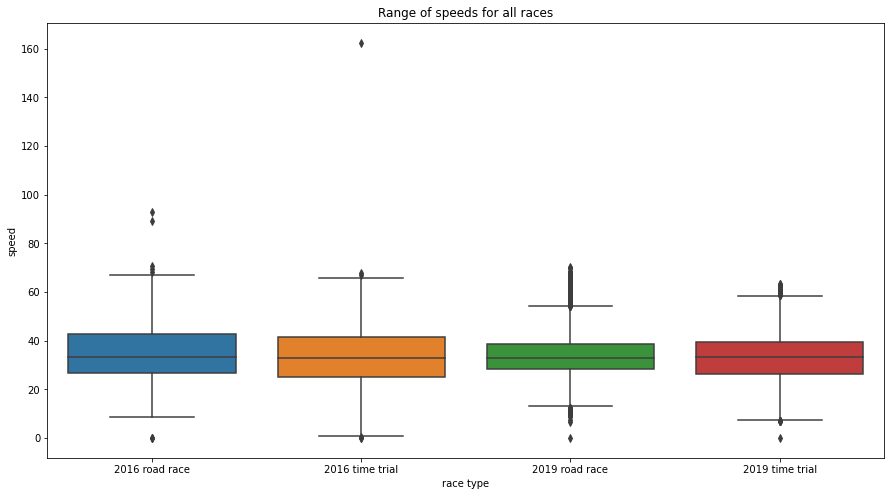

In [36]:
plt.figure(figsize=(15,8))

sns.boxplot(x='race type', y='speed', data= allDf)
plt.title('Range of speeds for all races')

I believe we can simply remove the outliers seen in tt_16 and rr_16. There are many data points in this data set so iit should not affect the overall analysis. I've decided that anything above 80 is an outlier as according to the following link, the max recorded speed a bicycle has achieved is 100kmph. I don't think Steve achieved this speed.

[WIKI](https://en.wikipedia.org/wiki/Bicycle_performance)

Checking for outliers. As mentioned previously, an outlier to check for speed would be speeds over 80kmph. We're able to apply this 'filter' to the data because realisticaly, we don't think the rider has achieved these speeds. Another indicator to confirm if the speeds are true is if the surrounding speeds are similar. They would be similar in a way that is decreasing or increasing slightly with each observation. In the plot above, we can see the speeds above 80 for races rr16 and tt16 have no neighbours, therefore they are outliers. 

In [37]:
allDf_clean = allDf[allDf['speed'] < 80] # keeping all rows except those that are greater than 80. 
# In other words, removing all rows greater than 80. I originally thought this would substitute the values iin 'speed'
# for boolean values instead. Like how a mask works. But this is not the case. 

# also applying to the DFs separately:

rr16_clean = rr16[rr16['speed'] < 80]
tt16_clean = tt16[tt16['speed'] < 80]
rr19_clean = rr19[rr19['speed'] < 80]
tt19_clean = tt19[tt19['speed'] < 80]

In [38]:
# checking the amount of outliers removed:

allDf.shape[0] - allDf_clean.shape[0]

3

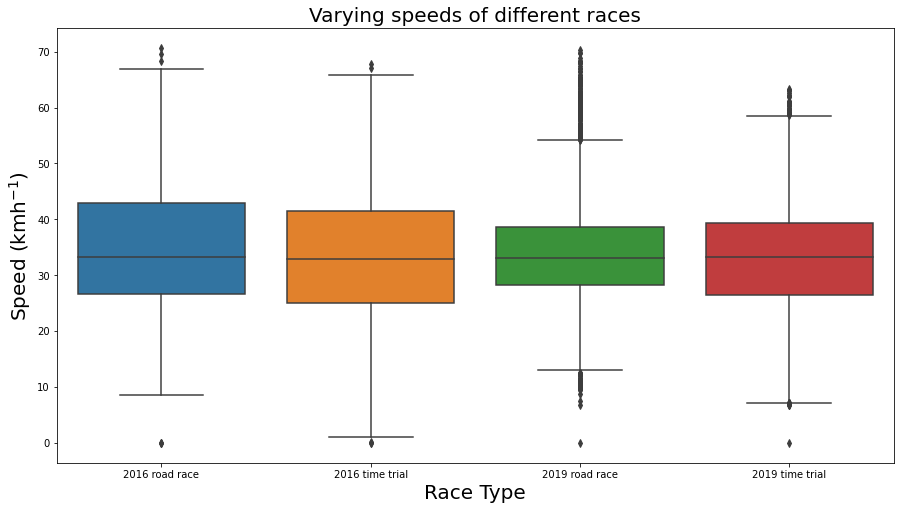

In [39]:
# plotting again

plt.figure(figsize=(15,8))

ax = sns.boxplot(x='race type', y='speed', data= allDf_clean)
ax.set_xlabel('Race Type', fontsize=20)
ax.set_ylabel('Speed (kmh$^{-1}$)', fontsize=20)
ax.set_title('Varying speeds of different races', fontsize= 20)

plt.show()

We can see there are still 'outliers' at the zero mark, and above the maximum. These are outliers defined by how the boxplot is produced. They aren't necessarily 'bad' data, but relate more to the boxplot itself. It should be noted that any time data is removed from the DF, the shape of the boxplot and the values determined by the boxplot will also change. In this case it's not obvious because only 3 points of data have been removed. 

Instead of removing the 3 outliers, we can try correcting them. This would involved taking the average of the two above the outlier and the two below. First we will organise the DF a little bit by resetting the index so it will be easier to index into the DF. We will also add a column to depict which race is in question. This will be handy for plotting and distinguishing between DFs when we append all the DFs. 

In [40]:
# if we know a value in the DF, but we don't know the index value, following will show how 
# to determine the index

rr16_reset = rr16.reset_index() #first reset the index column which will create a new 'index'
# column that contains the data from the old index. The new index will be numbered 
# as we traditionally expect, starting from 0. 

# test.loc[test['timedelta'] >10].index[1] 
# this will find all values greater than ten and 
#have them in their own array. 

# test.iloc[1538] 
# how to index the dataframe from the index column

In [41]:
rr16_reset = rr16.rename(columns={'index':'observation'}) # changing the name of the 'index' column to 
# observation so that we don't get confused with the index. 

In [42]:
rr16_reset.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race


In [43]:
def resetIndexFn(myDf, raceTypeString):
    myDf = myDf.reset_index()
    
    myDf = myDf.rename(columns={'index':'observation'})
    
    myDf['race type']= raceTypeString

    return myDf

Note, in the above cell we added a column to show what race type. This has been done previously, though it's being called again. It will not add another column, it will simply overwrite the current column.

In [44]:
rr16_reset = resetIndexFn(rr16, '2016 road race')

In [45]:
rr16_reset.head()

,observation,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type
0,2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race
1,2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race
2,2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race
3,2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race
4,2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race


Using `resetIndexFn` on the other DFs

In [46]:
tt16_reset = resetIndexFn(tt16, '2016 time trial')
rr19_reset = resetIndexFn(rr19, '2019 road race')
tt19_reset = resetIndexFn(tt19, '2019 time trial')

Finding the outliers

In [47]:
rr16_reset[rr16_reset['speed']>80].index

Int64Index([482, 1299], dtype='int64')

This race only has two speed outliers that are faster than 80kmph. What was output above is the indices where the speed outliers exist. We can store these to call later. 

In [48]:
rr16_outliersIndex = rr16_reset[rr16_reset['speed']>80].index

Taking the average of the two above and below the outlier. We will then store that value to update the DF with the corrected value.

In [49]:
rr16_reset['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]

480    30.896364
481     0.000000
482    89.394487
483    30.540313
484    31.287927
Name: speed, dtype: float64

In [50]:
mean1 =  rr16_reset['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]-1].mean()
mean2 = rr16_reset['speed'].iloc[rr16_outliersIndex[0]+1:rr16_outliersIndex[0]+3].mean()
mean = (mean1+mean2)/2

rr16_clean = rr16_reset
rr16_clean['speed'].iloc[rr16_outliersIndex[0]] = mean 

rr16_clean['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]


C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


480    30.896364
481     0.000000
482    30.905242
483    30.540313
484    31.287927
Name: speed, dtype: float64

We can see index 481 also has an outlier, being zero. We might as well fix that while we're here as it's highly unlikely the rider stopped and started in the span of a 1s window. 

In [51]:
rr16_clean['speed'].iloc[481] = mean 
rr16_clean['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]

480    30.896364
481    30.905242
482    30.905242
483    30.540313
484    31.287927
Name: speed, dtype: float64

We can confirm this is in the span of a 1s window by look at the `timedelta` column. 

In [52]:
rr16_clean['timedelta'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]

480    6.0
481    2.0
482    1.0
483    1.0
484    1.0
Name: timedelta, dtype: float64

The deceleration is possible, decreasing speed to zero in 6 seconds. Though the increase in speed back up to 30kmph in 2 seconds is not possible. We will leave index 481 corrected. 

Perfoming the same correction on the other DFs using a function

In [53]:
def cleanFn(myDf): 
    outlierIndex = myDf[myDf['speed']>80].index
    
    for i in outlierIndex:
        mean1 =  myDf['speed'].iloc[i -2:i-1].mean()
        mean2 = myDf['speed'].iloc[i+1:i+3].mean()
        mean = (mean1+mean2)/2
        myDf['speed'].iloc[i] = mean 

#         myDf['speed'].iloc[i-2:i+3]
        print(myDf['speed'].iloc[i-2:i+3])
#         print(i)
    return myDf

First, let's confirm the function works correctly:

In [54]:
rr16_clean = cleanFn(rr16_reset)
# rr16_clean
# cleanFn(rr16_reset)

1297    41.715290
1298     0.000000
1299    43.397047
1300    45.563577
1301    44.594033
Name: speed, dtype: float64


C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [55]:
print(rr16_clean['speed'].iloc[rr16_outliersIndex[1]-2:rr16_outliersIndex[1]+3])

1297    41.715290
1298     0.000000
1299    43.397047
1300    45.563577
1301    44.594033
Name: speed, dtype: float64


In [56]:
tt16_clean = cleanFn(tt16_reset)

867    40.157765
868     0.000000
869    36.466411
870    33.768855
871    31.781257
Name: speed, dtype: float64


C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [57]:
rr19_clean = cleanFn(rr19_reset)

In [58]:
tt19_clean = cleanFn(tt19_reset)

There is no outputs from calling the function for the 2019 races, so there are no outliers that exist above 80kmph. 

In [59]:
allDf_clean = rr16_clean.append([tt16_clean, rr19_clean, tt19_clean])

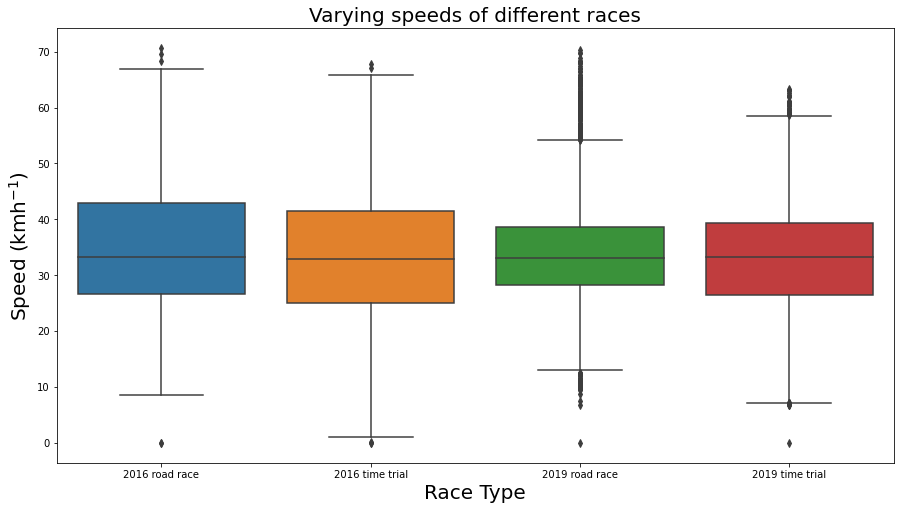

In [60]:
# plotting again

plt.figure(figsize=(15,8))

ax = sns.boxplot(x='race type', y='speed', data= allDf_clean)
ax.set_xlabel('Race Type', fontsize=20)
ax.set_ylabel('Speed (kmh$^{-1}$)', fontsize=20)
ax.set_title('Varying speeds of different races', fontsize= 20)

plt.show()

### **Analysis**: 

Now that most of the outliers have been removed, the y axis has decreased and we can see variations in the speeds more clearly. 

Both races in 2016 had higher variations in speed than those in 2019 and 2016. The earlier races also had a higher maximum speed and a lower minimum speed. The 2016 road race having the fastest speed overall and the 2019 time trial having the slow speed overall. Perhaps the races in 2019 had lower variations in speed due to the rider aging. The 2019 road race has a smaller range of speeds compared to the 2019 time trial. 

### Attempting rolling mean
After this attempt, I realised why this method didn't work. It will have just averaged the entire dataset rather than the outliers we're concerned with. The outliers would have changed in value only by a little bit, as can see in the box plot. 

rolling mean didn't really work. do the other method of fixing outliers

find the outliers, whether they are recording errors, replace the value with the number before it and after averaged. (maybe called contextual imputation) 

# check distribution plots

# Q3: Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  

We want to compare the speeds of the two `tt`. A comparison can include the mean of the races, the variations of speed over time. I dont think we can plot time because the observation column is in the wrong format. Can probably use the index since it's numbered. we would then say time as at observation 1 or 1000 for example. Those observations will have their own time stored in the observation column. 

We know from the `summaryFn`s for these races that they took 0.7397 and 0.7375hrs respectively to complete the races. We can also see the mean speeds of both races:


In [61]:
tt19_clean['speed'].mean()

33.05782378815691

In [62]:
tt16_clean['speed'].mean()

33.44817242372285

In [63]:
print(f'tt19 mean speed: {round(tt19_clean["speed"].mean(),2)}')
print(" ")
print(f'tt16 mean speed: {round(tt16_clean["speed"].mean(),2)}')

tt19 mean speed: 33.06
 
tt16 mean speed: 33.45


The average speed for both races are very similar. There isn't much to infer from here besides no improvement in the pace between the races. Both races were finished in a similar time and similar average speed. Although, as we've seen previously, the tt19 had a lower hrMean which can be seen in `summaryFn` indicating the fitness in the rider has improved. 

# Questions

Considering there are significantly more rows in tt19, would this mean the race has more observations and thus the race is longer? they took the same amount of time to complete the race and similar total distance travelled, so perhaps the additional rows is simply more observations. I'm not sure how this affects the data overall, though. 

What does it mean for matching up the observations? 

In [64]:
tt19_clean['distance_cumsum'] = tt19_clean['distance'].cumsum()
tt16_clean['distance_cumsum'] = tt16_clean['distance'].cumsum()

In [65]:
print(tt16_clean.shape, tt19_clean.shape)

(1541, 13) (2655, 14)


The number of columns do not match as we've removed the 'power' column from the DF due to the enttire column being null. 

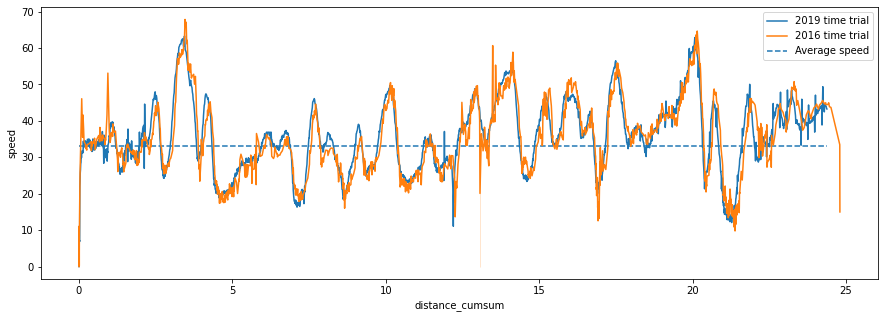

In [66]:
plt.figure(figsize=(15,5))

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt19_clean, label= '2019 time trial')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_clean, label= '2016 time trial')
plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_clean['distance_cumsum'].max(), linestyle = 'dashed', label= 'Average speed')
plt.legend()

The points match up well. I did not believe it would be this close as the number of rows in tt19 is nearly double that of tt16. More data should have a smoother shape. Considering tt19 has more observations, we can see the lines are slightly smoother. 

We can smooth out the entire dataset for both DFs by using the `rolling_mean` function. 

In [67]:
tt16_roll = tt16_clean.rolling(10,min_periods= 1).mean()

Plotting again to see if there are any improvements in the amount of 'noise'. 

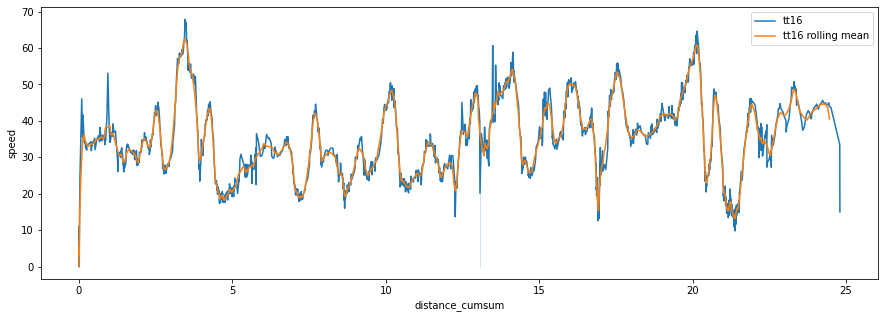

In [68]:
plt.figure(figsize=(15,5))

# sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt19_clean, label= '2019 time trial')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_clean, label= 'tt16')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= 'tt16 rolling mean')
# plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_clean['distance_cumsum'].max(), linestyle = 'dashed', label= 'Average speed')
plt.legend()

Using the documentation for subplots from here

https://seaborn.pydata.org/tutorial/axis_grids.html

We use subplots to show the two plots in one output cell. 

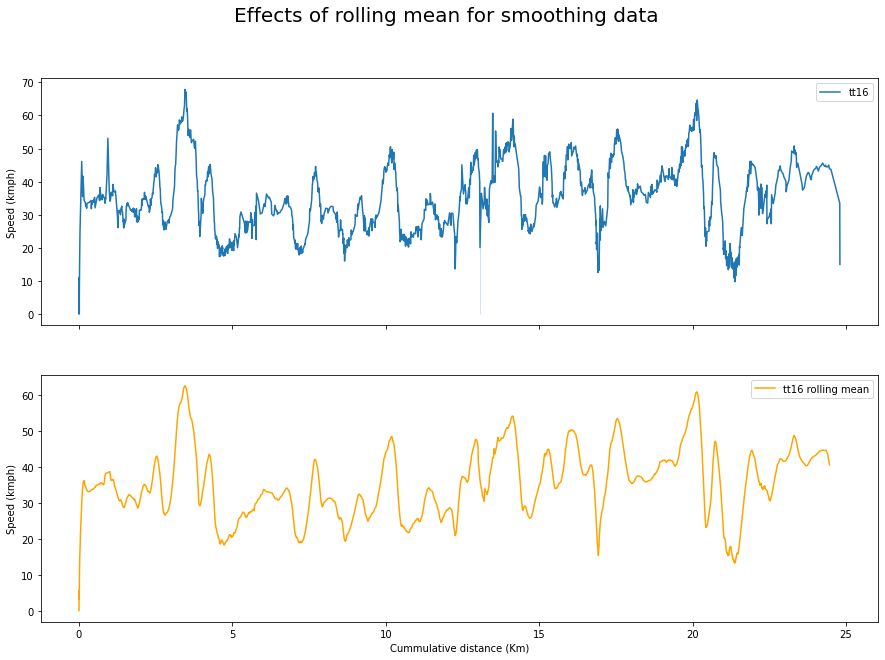

In [69]:
fig, axes = plt.subplots(2, figsize=(15,10), sharex= True)
# fig, axes = plt.subplots(2, figsize=(15,5), sharey= True)
fig.suptitle('Effects of rolling mean for smoothing data', size = 20)

ax1 = sns.lineplot(ax=axes[0], x= 'distance_cumsum', y= 'speed', data = tt16_clean, label= 'tt16')

ax2 = sns.lineplot(ax = axes[1], x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= 'tt16 rolling mean', color= 'orange')
# axes[1,0].set_title('tt16 rolling mean')

ax1.set(ylabel = 'Speed (kmph)')
ax2.set(ylabel = 'Speed (kmph)', xlabel = 'Cummulative distance (Km)')
# plt.ylabe('test')

# plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_clean['distance_cumsum'].max(), linestyle = 'dashed', label= 'Average speed')
plt.legend()

We can see well the effects the `rolling_mean` function had on the data. Let's apply this to the tt19 data. 

In [70]:
tt19_roll = tt19_clean.rolling(10,min_periods= 1).mean()

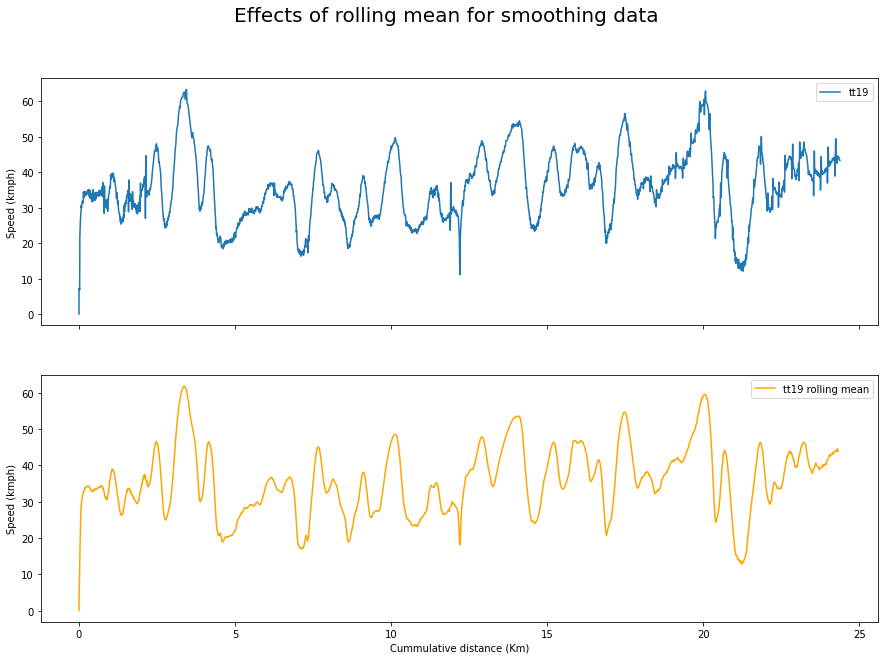

In [71]:
fig, axes = plt.subplots(2, figsize=(15,10), sharex= True)
# fig, axes = plt.subplots(2, figsize=(15,5), sharey= True)
fig.suptitle('Effects of rolling mean for smoothing data', size = 20)

ax1 = sns.lineplot(ax=axes[0], x= 'distance_cumsum', y= 'speed', data = tt19_clean, label= 'tt19')

ax2 = sns.lineplot(ax = axes[1], x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= 'tt19 rolling mean', color= 'orange')
# axes[1,0].set_title('tt16 rolling mean')

ax1.set(ylabel = 'Speed (kmph)')
ax2.set(ylabel = 'Speed (kmph)', xlabel = 'Cummulative distance (Km)')
# plt.ylabe('test')

# plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_clean['distance_cumsum'].max(), linestyle = 'dashed', label= 'Average speed')
plt.legend()

Let's see how the tt19 and tt16 smoothed looks like on the same plot

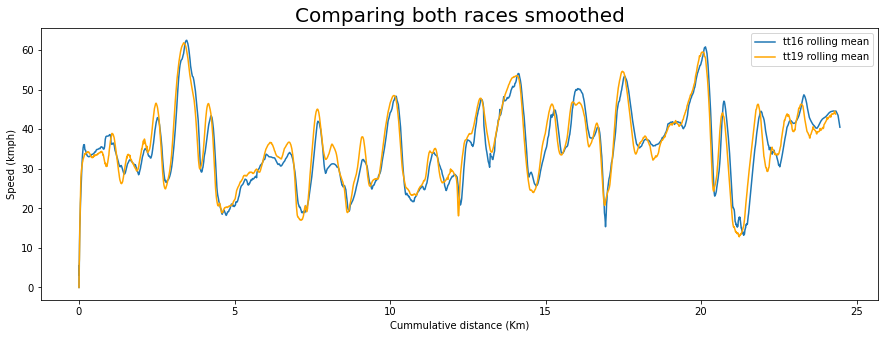

In [72]:
plt.figure(figsize=(15,5))

# fig, axes = plt.subplots(2, figsize=(15,10), sharex= True)
# fig, axes = plt.subplots(2, figsize=(15,5), sharey= True)
plt.title('Comparing both races smoothed', size = 20)

ax1 = sns.lineplot( x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= 'tt16 rolling mean')

ax2 = sns.lineplot( x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= 'tt19 rolling mean', color= 'orange')
# axes[1,0].set_title('tt16 rolling mean')

ax1.set(ylabel = 'Speed (kmph)')
ax2.set(ylabel = 'Speed (kmph)', xlabel = 'Cummulative distance (Km)')
# plt.ylabe('test')

# plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_clean['distance_cumsum'].max(), linestyle = 'dashed', label= 'Average speed')
plt.legend()


There are some areas that can be seen where one race is faster than  the other. Let's try to mark the obvious peaks and compare the speeds at those moments. We will only consider peaks that are above the average speed. There are still many peaks above the mean speed so we will also include a prominence factor in the peaks. This will find the most prominent peaks, reducing the total number of peaks, thus making it the most 'obvious' peaks. 

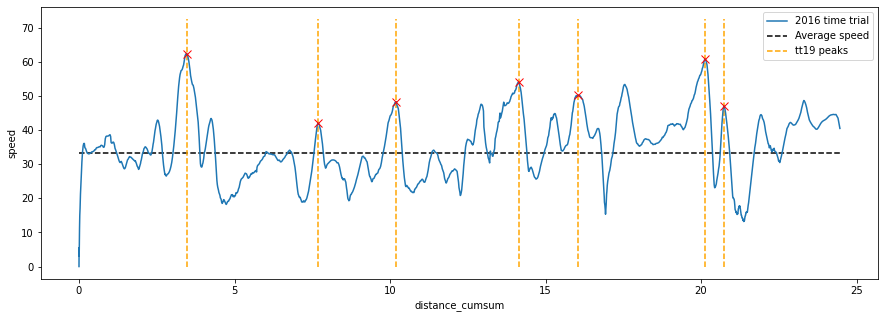

In [77]:
from scipy.signal import find_peaks

plt.figure(figsize=(15,5))


tt16_peaks, _=find_peaks(tt16_roll['speed'], height= tt16_roll['speed'].mean(), prominence= 22)
#peaks is storing the index 

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= '2016 time trial')

plt.hlines(y=tt16_roll['speed'].mean(), xmin=0, xmax= tt16_roll['distance_cumsum'].max(),
           linestyle = 'dashed', label= 'Average speed', color='black')

plt.plot( tt16_roll['distance_cumsum'][tt16_peaks], tt16_roll['speed'][tt16_peaks],
         "x",color='red', markersize= 8)

plt.vlines(x= tt16_roll['distance_cumsum'][tt16_peaks], ymin=tt16_roll['speed'].min(), 
           ymax= tt16_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt19 peaks', 
           color = 'orange')

plt.legend()

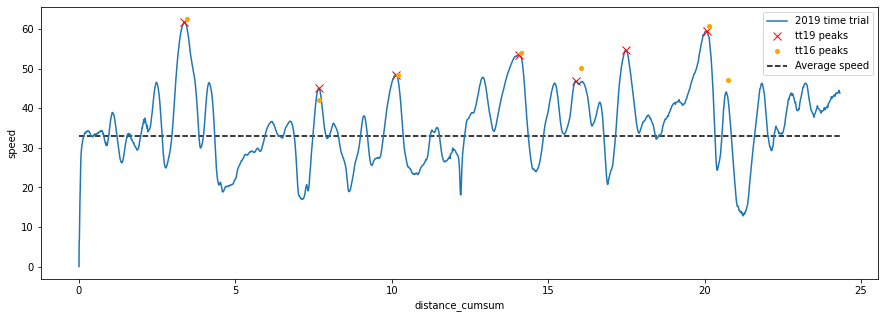

In [74]:
from scipy.signal import find_peaks

plt.figure(figsize=(15,5))


tt19_peaks, _=find_peaks(tt19_roll['speed'], height= tt19_roll['speed'].mean(), prominence= 22)
#peaks is storing the index where the peak occurs. 

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= '2019 time trial')
# sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= '2016 time trial')

plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_roll['distance_cumsum'].max(),
           linestyle = 'dashed', label= 'Average speed', color='black')

plt.plot( tt19_roll['distance_cumsum'][tt19_peaks], tt19_roll['speed'][tt19_peaks],
         "x",color='red', markersize= 8, label = 'tt19 peaks')

plt.plot( tt16_roll['distance_cumsum'][tt16_peaks], tt16_roll['speed'][tt16_peaks],
         ".",color='orange', markersize= 8, label= 'tt16 peaks')
# plt.vlines(x= tt16_clean['distance_cumsum'][tt16_peaks], ymin=tt16_clean['speed'].min(), 
#            ymax= tt16_clean['speed'].max()+10 ,linestyle = 'dashed', label= 'tt19 peaks', 
#            color = 'orange')

plt.legend()

In [75]:
tt19_peaks, _=find_peaks(tt19_roll['speed'], height= tt19_roll['speed'].mean(), prominence= 22)

Text(0.5, 1.0, 'Comparison of most obvious peaks')

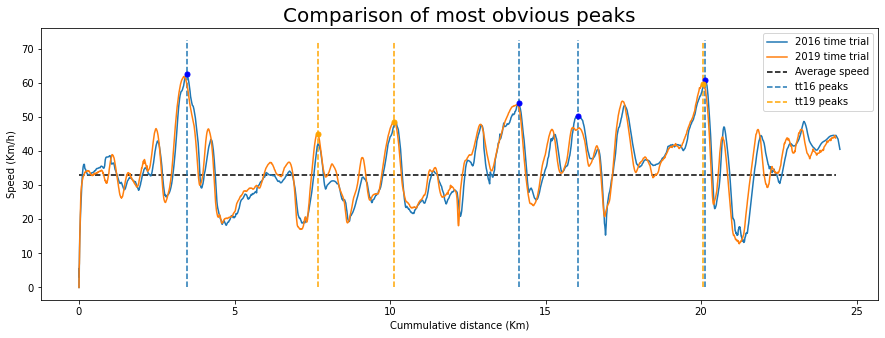

In [76]:
plt.figure(figsize=(15,5))

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= '2016 time trial')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= '2019 time trial')

plt.hlines(y=tt19_clean['speed'].mean(), xmin=0, xmax= tt19_roll['distance_cumsum'].max(),
           linestyle = 'dashed', label= 'Average speed', color='black')

tt16_peaksNew= []
tt19_peaksNew= []
for i, val in enumerate(tt19_peaks):
    if tt19_roll['speed'].iloc[val] > tt16_roll['speed'].iloc[tt16_peaks[i]]:
        tt19_peaksNew.append(val)
        plt.plot( tt19_roll['distance_cumsum'][val], tt19_roll['speed'][val],
         ".",color='orange', markersize= 10)
    else:
        tt16_peaksNew.append(tt16_peaks[i])
        plt.plot( tt16_roll['distance_cumsum'][tt16_peaks[i]], tt16_roll['speed'][tt16_peaks[i]],
         ".", markersize= 10 , color= 'blue')
# print(tt16_peaksNew)
# print(tt19_peaksNew)


plt.vlines(x= tt16_roll['distance_cumsum'][tt16_peaksNew], ymin=tt16_roll['speed'].min(), 
           ymax= tt16_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt16 peaks')

plt.vlines(x= tt19_roll['distance_cumsum'][tt19_peaksNew], ymin=tt19_roll['speed'].min(), 
           ymax= tt19_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt19 peaks', color = 'orange')





# plt.legend(['tt19','Average speed','tt16 peak','tt19', 'test', 'test','test'])
plt.legend()

plt.xlabel('Cummulative distance (Km)')
plt.ylabel('Speed (Km/h)')
plt.title('Comparison of most obvious peaks', size= 20)

We can see visually which race is faster thanks to the marked peaks. We can also check the value by indexing into the DFs with the variables. Let's do the same over the span of time passed during the race. 

We first have to get the cummulative time passed, similarly to how we did for the cummulative distance. We will have to make a new column. 

In [78]:
tt16_roll

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,distance_cumsum
0,-33.415971,151.222016,111.80,12.00,58.0,108.0,0.000000,0.00,0.000000,NaN,0.000000
1,-33.415999,151.222012,111.80,12.00,58.0,106.5,0.003080,0.00,5.544567,2.000000,0.003080
2,-33.416010,151.222016,111.80,12.00,58.0,106.0,0.002604,0.00,4.026805,4.000000,0.004658
3,-33.416018,151.222021,111.80,12.25,58.0,104.5,0.002352,0.00,3.082518,10.333333,0.005845
4,-33.416024,151.222028,111.80,12.40,59.4,103.8,0.002201,0.00,3.614428,8.000000,0.006877
...,...,...,...,...,...,...,...,...,...,...,...
1536,-33.414045,151.220692,116.42,11.00,99.7,161.2,0.042087,-0.06,44.634889,3.400000,24.256180
1537,-33.414376,151.220910,116.30,11.00,99.8,161.6,0.042046,-0.12,44.561608,3.400000,24.298226
1538,-33.414699,151.221121,116.18,11.00,89.8,161.8,0.040902,-0.12,44.612415,3.300000,24.339129
1539,-33.415219,151.221462,115.32,11.00,86.2,160.1,0.066024,-0.86,43.523388,6.100000,24.405152


In [ ]:
tt16_roll['time'] = tt16_roll['']

highest peaks indicate going downhill, can determine how long youve been going downhill for.

smooth data out, check if one race was faster in one half of the race compared to the other. 


### SHOULD ALSO DO THE SAME FOR TIME INSTEAD OF distance_cumsum

In [ ]:
# example for find_peaks 

import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
x = electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x, height=0, distance = 300)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

# Q4: From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

In [ ]:
tt16_clean['elevation_gain'].describe()

Trying to convert the >0 to incline, =0 flat and < 0 to decline. 1 for incline, 0 for flat and -1 for decline. 

In [2]:
tt16_clean.shape

NameError: name 'tt16_clean' is not defined

Checking if the dimensions work if a mask is applied to the DF

In [ ]:
tt16_clean[tt16_clean['elevation_gain'] < 0].shape[0] + tt16_clean[tt16_clean['elevation_gain'] > 0].shape[0] + tt16_clean[tt16_clean['elevation_gain'] == 0].shape[0] 

applying the 'binarizer'. Not truly a binarizer as we've included -1

In [150]:
index_decl = tt16_clean[tt16_clean['elevation_gain'] < 0]['elevation_gain'].index
tt16_clean['elevation_gain'].iloc[index_decl] = -1

index_incl = tt16_clean[tt16_clean['elevation_gain'] > 0]['elevation_gain'].index
tt16_clean['elevation_gain'].iloc[index_incl] = 1

index_flat = tt16_clean[tt16_clean['elevation_gain'] == 0]['elevation_gain'].index
tt16_clean['elevation_gain'].iloc[index_flat] = 0

C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Text(0.5, 0, 'Elevation gain ')

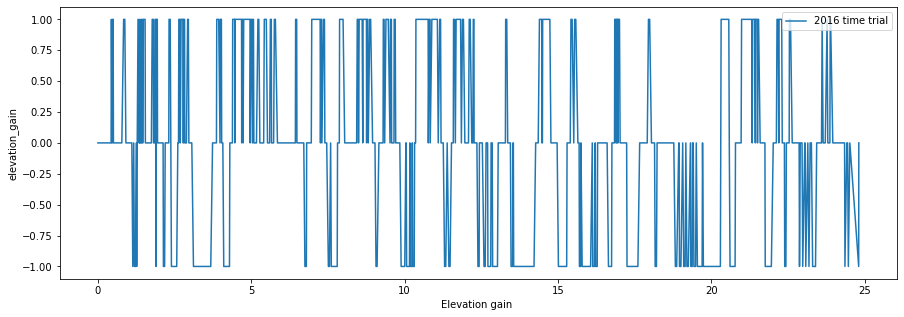

In [160]:
plt.figure(figsize=(15,5))


# sns.lineplot(x= 'distance_cumsum', y= 'elevation', data = tt16_clean, label= '2016 time trial')
sns.lineplot(x= 'distance_cumsum', y= 'elevation_gain', data = tt16_clean, label= '2016 time trial')
# sns.distplot(x= tt16_roll['elevation_gain'], label= '2016 time trial')

plt.xlabel('Elevation gain ')
# plt.xlim(0,10)

Let's check if there is an outlier

In [ ]:
tt16_clean[tt16_clean['elevation_gain'] <-5]

only one possible outlier. Ideally, we would want to find the outlier by checking the change in elevation_gain with change in time. 

In [ ]:
tt16_clean[['observation','elevation_gain']].iloc[1535:1540]

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





# NEED HELP FOR THE FOLLOWING: 

- how to use smoothing function 
- is my analysis of the boxplot correrct? I feel im missing something. perhaps it's better represented visually using something else. 